<a href="https://colab.research.google.com/gist/veithweilnhammer/e0f7efe36480c7d3c64b3d5d4d73d8cd/01-explore-ibl-behavior-data-pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About this resource

All of the tutorial notebooks as well as information about the dependent package (`nma-ibl`) can be found at [nma-ibl GitHub repository](https://github.com/int-brain-lab/nma-ibl).

## Setting up the environment (particularly for Colab users)

Please execute the cells below the install the necessary dependencies and prepare the environment.

In [1]:
# install IBL pipeline package to access and navigate the pipeline
!pip install --quiet nma-ibl

# Explore IBL data Pipeline

Welcome! This notebook gives you a brief introduction on the [International Brain Laboratory (IBL)](https://www.internationalbrainlab.com/) data pipeline, and provide quick guidance on how to explore the data pipeline utilizing [DataJoint](https://datajoint.io) -- the framework in which the pipeline has been developed.

## A little bit about DataJoint

[DataJoint](https://datajoint.io) is a general data pipeline framework offered in Python & MATLAB, that allows users to interact with a relational database (e.g. MySQL) intuitively and efficiently. Among many features, it offers a way to develop data pipelines with built-in integrity and consistency checks, and provides facility to define tables for computations with tools to quickly parallelize the processing over multiple computers! To learn more, please visit the website [DataJoint.io](https://datajoint.io). There you will find links to our interactive playgrounds and tutorials. 

[Vathes](https://vathes.com) and, in particular, [DataJoint Neuro](https://djneuro.io) is the team that develops and maintains DataJoint, and also help researchers and labs to adopt DataJoint and design pipeline.

Using DataJoint framework, we have been processing data daily within IBL project, and provides a website that displays data and visualizations for the daily training results at https://data.internationalbrainlab.org.

## Navigating the IBL data pipeline

Here we will go through some useful tools to navigate through and get familiar with the data as foundin the pipeline.

First thing first, let's **import DataJoint and the IBL pipeline package**.

In [2]:
import datajoint as dj

We'll then need to configure DataJoint to connect to the IBL public database hosted at datajoint-public.internationalbrainlab.org.
Please be sure to fill in your credentials, replacing the `{USERNAME}` and `{PASSWORD}` with the actual username and password you received in the email after signing for IBL data access through the DataJoint.io webiste. If you are missing this information, please visit the [NMA-IBL GitHub repository](https://github.com/int-brain-lab/nma-ibl) to find out how to gain data pipeline access.

In [3]:
dj.config['database.host'] = 'datajoint-public.internationalbrainlab.org'
dj.config['database.user'] = 'nma-ibl-public'
dj.config['database.password'] = 'ibl.pipeline.public.demo'

and now we'll import specific IBL data pipeline resources to navigate and access the data (this may take some time to run as it establishes access and fetch relevant resources from the database).

In [4]:
from nma_ibl import reference, subject, action, acquisition, data, behavior, behavior_analyses

Connecting nma-ibl-public@datajoint-public.internationalbrainlab.org:3306


# 1. Browse schemas you have access to - `dj.list_schemas()`

One or more related tables are grouped together into "schemas", providing for logical structure and organization of tables. Tables belonging to the schema are related to each other in intuitive fashion.

You can list what schemas can be found in the IBL data pipeline as follows:

In [5]:
dj.list_schemas()

['ibl_acquisition',
 'ibl_action',
 'ibl_analyses_behavior',
 'ibl_behavior',
 'ibl_data',
 'ibl_ephys',
 'ibl_reference',
 'ibl_storage',
 'ibl_subject']

## Major schemas:   

Different schemas in the pipeline correspond to different grouping of related information, and typically associated with different *data sources*.

1. Meta data stored and imported from [**Alyx**](https://alyx.readthedocs.io/en/latest/):

    1) `ibl_reference`: general information about labs, users and projects  
    2) `ibl_subject`: information about the experiment subject including housing and genetics  
    3) `ibl_action`: information about performed surgeries
    4) `ibl_acquisition`: information about experimental sessions
    5) `ibl_data`: information pertaining to underlying data resource handling  
    
2. Behavioral data stored and imported from **FlatIron** data stores: `ibl_behavior` - trial information of the task.
3. Computed alalysis results on the behavioral data: `ibl_analyses_behavior`    

# 2. Browse tables in a schema - `dj.Diagram`

`dj.Diagram` shows the tables and the dependencies among them. There are four types of DataJoint tables, referred to as different *tiers*, and different types of dependencies:

### Table tiers  

**Manual table**: (green box) Entries in a manual table are inserted "manually" or by recording systems. This is the kind of data that if lost, it basically cannot be recovered without proper backups present. A typical example of a manual table is the `subject` table that saves information about animal subjects.

**Lookup table**: (gray box) Lookup tables hold general facts that rarely changes, such as a listing of possible genetic lines of an animals, or parameter information for a model.

**Imported table**: (blue oval) Entries in an imported table are loaded from as external data source, such as a recording file produced by the recording system. DataJoint offers a clean way to trigger and process the "ingestion" of such external data into an imported table. If deleted, the entries may be recoverable if external data source still exists. Examples of imported tables are tables for experimental recordings (e.g. behavioral traces or electrophysiology signals).  

**Computed table**: (red circle) Entries in an imported table are computed from data entirely present in the other tables within the pipeline. If deleted, the entries are typically easily recoverable through recomputation. Examples of computed tables are tables for behavioral analysis results.

**Part table**: (plain text) Part tables are tables tightly link to its master table, signifying that entires within the part tables should not be deleted without a corresponding deletion of the master table. Data for part tables are usually imported through the master table's logic.

### Dependencies

**One-to-one primary**: (thick solid line) Tables with one-to-one primary dependency have the exact same definition of the primary key. Under this dependency, (up to) only one entry can exist in the child table for every entry in the parent table. 

**One-to-many primary**: (thin solid line) The child table inherits the primary key definition from its parent, but has additional field as part of the primary key as well. There may exist any number of child table entries corresponding to a single entry in the parent table.

**Secondary foreign key reference**: (dashed line) A secondary attribute references to another table, but does not establish primary key dependencies. If any attributes are renamed during the dependency establishment, the link contains an orange dot.

Below we'll see how you can use `dj.Diagram` to view various parts of a schema, as well as to combine multilpe schemas into one diagram to capture dependencies acorss schemas.

### Show tables in the whole schema

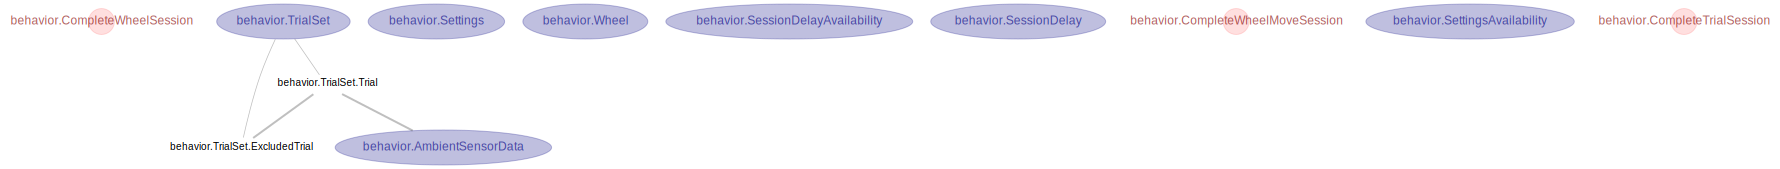

In [6]:
dj.Diagram(behavior)

### Show diagram combining aribtrary parts of the pipeline

A combination of aribtrary tables:

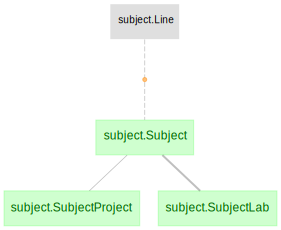

In [7]:
dj.Diagram(subject.Subject) + dj.Diagram(subject.Line) + dj.Diagram(subject.SubjectLab) + dj.Diagram(subject.SubjectProject)

The tables could be from different schemas:

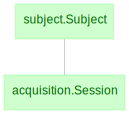

In [8]:
dj.Diagram(subject.Subject) + dj.Diagram(acquisition.Session)

# 3. Getting the detailed definition of a table - `table.describe()`

You can get "definition" of any table by calling `.describe()` method:

In [9]:
subject.Subject.describe();

subject_uuid         : uuid                         
---
subject_nickname     : varchar(255)                 # nickname
sex                  : enum('M','F','U')            # sex
subject_birth_date=null : date                         # birth date
ear_mark=null        : varchar(255)                 # ear mark
-> [nullable] subject.Line.proj(subject_line="line_name")
subject_strain=null  : varchar(255)                 
-> [nullable] subject.Source.proj(subject_source="source_name")
protocol_number      : tinyint                      # protocol number
subject_description=null : varchar(1024)                
subject_ts=CURRENT_TIMESTAMP : timestamp                    



# 4. Browsing of data - queries

We now show how you can navigate and access contents of the tables by writing `queries`. Below we provide a very brief overview of DataJoint queries with examples. For more thorough discussions and examples, please visit [DataJoint.io](https://datajoint.io) and [DataJoint Tutorials](https://tutorials.datajoint.io).

 A simplest query is the table itself - which simply corresponds to all entries in the table.

In [10]:
subject.Subject()

subject_uuid,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts
00778394-c956-408d-8a6c-ca3b05a611d5,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00
019a22c1-b944-4494-9e38-0e45ae6697bf,SWC_022,M,2019-06-18,NA (Front HP),C57BL/6J,None,Charles River,4,ID: 990762,2020-01-13 23:39:01
01be78e7-8741-4b40-bd64-79ed745431b5,CSHL057,M,2019-10-15,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:01
02120449-9b19-4276-a434-513886c2fb19,ibl_witten_07,F,2018-11-13,None,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:01
030f3e05-9db0-46ba-a6ce-4274ff09b39e,KS031,M,2019-12-10,None,C57BL/6J,None,None,3,None,2020-09-24 00:07:31
034fd43f-ee35-450b-99ef-25475ce25fdc,ZM_1092,M,2018-10-23,RLF,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:02
05e97eea-64e2-4e52-a78a-5b78875b4fa3,KS004,F,2018-12-04,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:03
0812d02d-d62b-416d-8b66-7956db34ee32,ibl_witten_19,M,2019-11-13,N/A,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:31
082fa374-a10c-4c47-9c50-1c23e7490e30,SWC_038,F,2019-12-11,X,C57BL/6J,None,Charles River,4,None,2020-09-24 00:07:31
088b6898-0a86-435e-b91f-eab829a846f6,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,None,Charles River,4,ID: 919175,2019-09-18 01:17:36


Notice that each query only gives you a quick preview of the data. We'll soon talk about how to "fetch" the data once you formulated a query capturing the data you want to grab.

## Restriction  `&`: filtering data

Restriction operation allows for narrow down the query to entries matcihng certain criteria.

### Restriction: Query one subject

In [11]:
# restrict by string
subject.Subject & 'subject_nickname="IBL-T1"'

subject_uuid,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts
cff66dc1-765e-4e04-abef-92de05bf4f19,IBL-T1,M,2018-11-27,1,None,None,None,1,None,2019-09-18 01:17:38


In [12]:
# restrict by a dictionary.
subject.Subject & {'subject_uuid': 'cff66dc1-765e-4e04-abef-92de05bf4f19'}

subject_uuid,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts
cff66dc1-765e-4e04-abef-92de05bf4f19,IBL-T1,M,2018-11-27,1,None,None,None,1,None,2019-09-18 01:17:38


In [13]:
subject.Subject & {'sex': 'm'}

subject_uuid,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts
019a22c1-b944-4494-9e38-0e45ae6697bf,SWC_022,M,2019-06-18,NA (Front HP),C57BL/6J,None,Charles River,4,ID: 990762,2020-01-13 23:39:01
01be78e7-8741-4b40-bd64-79ed745431b5,CSHL057,M,2019-10-15,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:01
030f3e05-9db0-46ba-a6ce-4274ff09b39e,KS031,M,2019-12-10,None,C57BL/6J,None,None,3,None,2020-09-24 00:07:31
034fd43f-ee35-450b-99ef-25475ce25fdc,ZM_1092,M,2018-10-23,RLF,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:02
0812d02d-d62b-416d-8b66-7956db34ee32,ibl_witten_19,M,2019-11-13,N/A,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:31
088b6898-0a86-435e-b91f-eab829a846f6,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,None,Charles River,4,ID: 919175,2019-09-18 01:17:36
0932d382-3fd4-4688-88d1-a0156cadd488,CSH_ZAD_007,M,2019-05-06,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:05
0a47477d-e76f-43d8-a5b3-9b985707ad3f,DY_013,M,2019-10-23,none,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:31
0cd0b05f-fbee-40c0-b2e2-07708c90dead,DY_015,M,2019-10-23,none,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:32
0fbb1324-1ac7-445a-8831-8fc2225338ca,CSH_ZAD_010,M,2019-05-06,none,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:07


### Restriction: Query subjects born after a date

In [14]:
subject.Subject & 'subject_birth_date > "2019-01-01"'

subject_uuid,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts
00778394-c956-408d-8a6c-ca3b05a611d5,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00
019a22c1-b944-4494-9e38-0e45ae6697bf,SWC_022,M,2019-06-18,NA (Front HP),C57BL/6J,None,Charles River,4,ID: 990762,2020-01-13 23:39:01
01be78e7-8741-4b40-bd64-79ed745431b5,CSHL057,M,2019-10-15,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:01
030f3e05-9db0-46ba-a6ce-4274ff09b39e,KS031,M,2019-12-10,None,C57BL/6J,None,None,3,None,2020-09-24 00:07:31
0812d02d-d62b-416d-8b66-7956db34ee32,ibl_witten_19,M,2019-11-13,N/A,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:31
082fa374-a10c-4c47-9c50-1c23e7490e30,SWC_038,F,2019-12-11,X,C57BL/6J,None,Charles River,4,None,2020-09-24 00:07:31
088b6898-0a86-435e-b91f-eab829a846f6,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,None,Charles River,4,ID: 919175,2019-09-18 01:17:36
0932d382-3fd4-4688-88d1-a0156cadd488,CSH_ZAD_007,M,2019-05-06,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:05
0a47477d-e76f-43d8-a5b3-9b985707ad3f,DY_013,M,2019-10-23,none,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:31
0bde9528-5bed-4ba5-a95a-a250cd769bbe,SWC_029,F,2019-08-16,R,None,None,None,1,None,2020-01-13 23:39:06


### Restriction: subjects within a range of dates

In [15]:
subject.Subject & 'subject_birth_date between "2019-01-01" and "2019-04-01"'

subject_uuid,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts
088b6898-0a86-435e-b91f-eab829a846f6,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,None,Charles River,4,ID: 919175,2019-09-18 01:17:36
0d219ef3-6282-4602-b99f-a40d06d99bb2,SWC_002,F,2019-01-19,L (Front HP),C57BL/6J,None,Charles River,4,ID: 919178,2020-01-13 23:39:06
10fd3170-6c52-4cb6-986f-aa73704277c0,CSHL_015,F,2019-02-19,None,C57BL/6J,None,Jax,3,None,2019-09-18 01:17:36
1a08c0fa-5646-4b68-9703-0dd6b805c69d,SWC_007,M,2019-03-27,NA (Rear HP),C57BL/6J,None,Charles River,4,None,2020-01-13 23:39:12
204d40b0-7ea8-49b3-835c-05b47ec8801b,ZM_1746,M,2019-02-24,RF,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:14
27d08c9d-6013-42d8-bab5-1e788f230b2e,SWC_001,F,2019-01-19,R (Front HP),C57BL/6J,None,Charles River,4,ID: 919179,2020-01-13 23:39:16
2bc03c63-c266-43bf-905e-5aa6ea71a294,ibl_witten_11,F,2019-03-19,NA,C57BL/6J,None,None,3,None,2019-09-18 01:17:37
2f1b7046-9c58-4076-a7c5-7c386293dc89,DY_006,M,2019-03-20,none,C57BL/6J,None,Jax,3,None,2019-09-18 01:17:37
3b6b41b6-68bb-4a9a-bfeb-5f8cf97a1c2a,ZM_1745,M,2019-02-24,None,C57BL/6J,None,Jax,3,None,2019-09-18 01:17:37
475acc5f-64f7-4f28-9722-5f60ce553f91,DY_007,M,2019-03-20,none,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:26


### Restriction: Query subjects on multiple attributes

In [16]:
subject.Subject & 'subject_birth_date > "2019-01-01"' & 'sex="M"'

subject_uuid,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts
019a22c1-b944-4494-9e38-0e45ae6697bf,SWC_022,M,2019-06-18,NA (Front HP),C57BL/6J,None,Charles River,4,ID: 990762,2020-01-13 23:39:01
01be78e7-8741-4b40-bd64-79ed745431b5,CSHL057,M,2019-10-15,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:01
030f3e05-9db0-46ba-a6ce-4274ff09b39e,KS031,M,2019-12-10,None,C57BL/6J,None,None,3,None,2020-09-24 00:07:31
0812d02d-d62b-416d-8b66-7956db34ee32,ibl_witten_19,M,2019-11-13,N/A,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:31
088b6898-0a86-435e-b91f-eab829a846f6,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,None,Charles River,4,ID: 919175,2019-09-18 01:17:36
0932d382-3fd4-4688-88d1-a0156cadd488,CSH_ZAD_007,M,2019-05-06,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:05
0a47477d-e76f-43d8-a5b3-9b985707ad3f,DY_013,M,2019-10-23,none,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:31
0cd0b05f-fbee-40c0-b2e2-07708c90dead,DY_015,M,2019-10-23,none,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:32
0fbb1324-1ac7-445a-8831-8fc2225338ca,CSH_ZAD_010,M,2019-05-06,none,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:07
12385eb1-eb86-496d-91c6-a4bd7392376a,ibl_witten_18,M,2019-11-13,N/A,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:32


### Restriction: Query dead subjects

In [17]:
# subjects that are dead
subject.Subject & subject.Death

subject_uuid,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts
030f3e05-9db0-46ba-a6ce-4274ff09b39e,KS031,M,2019-12-10,None,C57BL/6J,None,None,3,None,2020-09-24 00:07:31
034fd43f-ee35-450b-99ef-25475ce25fdc,ZM_1092,M,2018-10-23,RLF,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:02
05e97eea-64e2-4e52-a78a-5b78875b4fa3,KS004,F,2018-12-04,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:03
082fa374-a10c-4c47-9c50-1c23e7490e30,SWC_038,F,2019-12-11,X,C57BL/6J,None,Charles River,4,None,2020-09-24 00:07:31
0a47477d-e76f-43d8-a5b3-9b985707ad3f,DY_013,M,2019-10-23,none,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:31
0cd0b05f-fbee-40c0-b2e2-07708c90dead,DY_015,M,2019-10-23,none,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:32
0d219ef3-6282-4602-b99f-a40d06d99bb2,SWC_002,F,2019-01-19,L (Front HP),C57BL/6J,None,Charles River,4,ID: 919178,2020-01-13 23:39:06
1308692a-7616-4147-b627-897ebec9c3b1,SWC_035,M,2019-10-22,NA,C57BL/6J,None,Charles River,1,None,2020-09-24 00:07:32
13e59361-a2e8-4e2d-8636-ae0961fd941c,ZM_1093,M,2018-10-23,None,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:10
19943d5d-7804-459b-84a7-9e2c5627402c,CSH_ZAD_024,M,2019-11-12,RR,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:32


In [18]:
# subjects that are alive
subject.Subject - subject.Death

subject_uuid,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts
00778394-c956-408d-8a6c-ca3b05a611d5,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00
019a22c1-b944-4494-9e38-0e45ae6697bf,SWC_022,M,2019-06-18,NA (Front HP),C57BL/6J,None,Charles River,4,ID: 990762,2020-01-13 23:39:01
01be78e7-8741-4b40-bd64-79ed745431b5,CSHL057,M,2019-10-15,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:01
02120449-9b19-4276-a434-513886c2fb19,ibl_witten_07,F,2018-11-13,None,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:01
0812d02d-d62b-416d-8b66-7956db34ee32,ibl_witten_19,M,2019-11-13,N/A,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:31
088b6898-0a86-435e-b91f-eab829a846f6,SWC_005,M,2019-02-05,NA (Rear HP),C57BL/6J,None,Charles River,4,ID: 919175,2019-09-18 01:17:36
0932d382-3fd4-4688-88d1-a0156cadd488,CSH_ZAD_007,M,2019-05-06,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:05
0936a724-2151-446f-98b2-92c3e9dd36dc,CSHL_007,F,2018-11-27,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:05
0bde9528-5bed-4ba5-a95a-a250cd769bbe,SWC_029,F,2019-08-16,R,None,None,None,1,None,2020-01-13 23:39:06
0d7d50d7-41c4-4bb9-bf67-d51f0dc83faa,ibl_witten_23,F,2019-12-03,NA,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:32


## Join `*`:  gather information from different tables

You can combine or "join" two tables with the `join` operator (`*`). The result represents *every valid combination* of entries across the two tables.

In [19]:
subject.Subject * acquisition.Session

subject_uuid,session_start_time start time,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts,session_uuid,session_number number,session_end_time end time,session_lab name of lab,session_location name of the location,task_protocol,session_type type,session_narrative,session_ts
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,fb9bdf18-76be-452b-ac4e-21d5de3a6f9f,1,2019-08-10 12:11:04,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-14 00:05:12
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-12 09:21:03,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,d47e9a4c-18dc-4d4d-991c-d30059ec2cbd,1,2019-08-12 10:07:19,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-14 00:01:02
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-13 10:28:45,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,e9a7e183-87fd-4a90-99b3-fdde0525a285,1,2019-08-13 11:23:10,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-14 00:02:47
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 09:37:17,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,07497983-2229-4cb2-8a45-50cee3fe9089,1,2019-08-14 09:59:03,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:41:45
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 11:35:16,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,6d94f1f8-7790-41e5-8b1f-75d4f853b3ff,2,2019-08-14 12:21:15,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:51:20
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-15 10:29:21,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,588a0b6b-ae77-4f54-96dc-0fb977b2a0c7,1,2019-08-15 11:14:35,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:50:13
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-16 17:00:11,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,b154670d-911b-4109-b330-5248dcaa3893,1,2019-08-16 17:45:04,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:57:21
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-19 09:12:02,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,a085ae45-5de8-4f45-bca2-41bf7ca65eae,1,2019-08-19 09:56:51,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:56:07
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-20 12:06:48,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,44f40b0c-0b32-43ff-b978-bbeedfe9e1f0,1,2019-08-20 12:55:24,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:47:28
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-21 11:21:03,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,1166a46e-3ed0-49ab-bb1a-3d56b4eac4da,1,2019-08-21 12:06:04,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:42:54


## Projection `.proj()`: focus on attributes of interest

projection allows you to narrow down the table by dropping unnecessary table attributes (except for primary key attributes which cannot be dropped).

In [20]:
# drop all but the primary key attributes
subject.Subject.proj()

subject_uuid
0bde9528-5bed-4ba5-a95a-a250cd769bbe
0f47b24d-3909-428c-a18d-666006c7c834
16816978-d32d-4647-83b4-055fcf993bf8
217d49ae-ada9-48be-a77e-9704c9e57855
2714cd11-363a-44bd-b57d-c91870ad0671
34ff50d4-42cf-41f7-8c38-ab631ca84d74
3eee82bf-8ccf-42ac-9e26-472caed5f265
54edfc98-ce84-471c-94a3-c748552fbc22
5644f7a6-e206-4da3-bd35-81d0f32153bb
5f02a7b6-b6cc-4690-8b21-ec34a384f0e6


In [21]:
# keep `subject_birth_date` and `sex`
subject.Subject.proj('subject_birth_date', 'sex')

subject_uuid,sex sex,subject_birth_date birth date
00778394-c956-408d-8a6c-ca3b05a611d5,F,2019-04-30
019a22c1-b944-4494-9e38-0e45ae6697bf,M,2019-06-18
01be78e7-8741-4b40-bd64-79ed745431b5,M,2019-10-15
02120449-9b19-4276-a434-513886c2fb19,F,2018-11-13
030f3e05-9db0-46ba-a6ce-4274ff09b39e,M,2019-12-10
034fd43f-ee35-450b-99ef-25475ce25fdc,M,2018-10-23
05e97eea-64e2-4e52-a78a-5b78875b4fa3,F,2018-12-04
0812d02d-d62b-416d-8b66-7956db34ee32,M,2019-11-13
082fa374-a10c-4c47-9c50-1c23e7490e30,F,2019-12-11
088b6898-0a86-435e-b91f-eab829a846f6,M,2019-02-05


### rename attribute with ***proj()***

You could also use proj to rename attributes.

In [22]:
subject.Subject.proj('sex', dob='subject_birth_date')

subject_uuid,sex sex,dob birth date
00778394-c956-408d-8a6c-ca3b05a611d5,F,2019-04-30
019a22c1-b944-4494-9e38-0e45ae6697bf,M,2019-06-18
01be78e7-8741-4b40-bd64-79ed745431b5,M,2019-10-15
02120449-9b19-4276-a434-513886c2fb19,F,2018-11-13
030f3e05-9db0-46ba-a6ce-4274ff09b39e,M,2019-12-10
034fd43f-ee35-450b-99ef-25475ce25fdc,M,2018-10-23
05e97eea-64e2-4e52-a78a-5b78875b4fa3,F,2018-12-04
0812d02d-d62b-416d-8b66-7956db34ee32,M,2019-11-13
082fa374-a10c-4c47-9c50-1c23e7490e30,F,2019-12-11
088b6898-0a86-435e-b91f-eab829a846f6,M,2019-02-05


### perform simple computations with ***proj***

projection also provides for capacity to compute a new field on the fly based on attributes present in the query.

**Example 1: Get date of a session:**

In [23]:
sessions_with_date = acquisition.Session.proj(session_date='DATE(session_start_time)')

In [24]:
sessions_with_date

subject_uuid,session_start_time start time,session_date calculated attribute
15f98ab5-20d8-4345-a5de-21912a39575f,2019-12-23 13:28:10,2019-12-23
0f47b24d-3909-428c-a18d-666006c7c834,2019-12-12 15:06:17,2019-12-12
17715189-8c56-4c3a-81c6-eec2f68bbf10,2020-03-13 12:48:55,2020-03-13
17715189-8c56-4c3a-81c6-eec2f68bbf10,2020-03-16 11:44:27,2020-03-16
17715189-8c56-4c3a-81c6-eec2f68bbf10,2020-03-17 11:33:23,2020-03-17
17715189-8c56-4c3a-81c6-eec2f68bbf10,2020-03-18 13:14:55,2020-03-18
17715189-8c56-4c3a-81c6-eec2f68bbf10,2020-03-19 11:28:38,2020-03-19
17715189-8c56-4c3a-81c6-eec2f68bbf10,2020-03-20 11:41:51,2020-03-20
17715189-8c56-4c3a-81c6-eec2f68bbf10,2020-03-23 09:46:20,2020-03-23
217d49ae-ada9-48be-a77e-9704c9e57855,2019-03-27 13:42:13,2019-03-27


**Example 2: Age of the animal when performing each session?**

In [25]:
# First get the date of birth and the session date into the same query
q = subject.Subject * acquisition.Session

In [26]:
q

subject_uuid,session_start_time start time,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts,session_uuid,session_number number,session_end_time end time,session_lab name of lab,session_location name of the location,task_protocol,session_type type,session_narrative,session_ts
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,fb9bdf18-76be-452b-ac4e-21d5de3a6f9f,1,2019-08-10 12:11:04,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-14 00:05:12
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-12 09:21:03,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,d47e9a4c-18dc-4d4d-991c-d30059ec2cbd,1,2019-08-12 10:07:19,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-14 00:01:02
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-13 10:28:45,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,e9a7e183-87fd-4a90-99b3-fdde0525a285,1,2019-08-13 11:23:10,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-14 00:02:47
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 09:37:17,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,07497983-2229-4cb2-8a45-50cee3fe9089,1,2019-08-14 09:59:03,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:41:45
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 11:35:16,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,6d94f1f8-7790-41e5-8b1f-75d4f853b3ff,2,2019-08-14 12:21:15,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:51:20
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-15 10:29:21,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,588a0b6b-ae77-4f54-96dc-0fb977b2a0c7,1,2019-08-15 11:14:35,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:50:13
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-16 17:00:11,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,b154670d-911b-4109-b330-5248dcaa3893,1,2019-08-16 17:45:04,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:57:21
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-19 09:12:02,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,a085ae45-5de8-4f45-bca2-41bf7ca65eae,1,2019-08-19 09:56:51,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:56:07
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-20 12:06:48,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,44f40b0c-0b32-43ff-b978-bbeedfe9e1f0,1,2019-08-20 12:55:24,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:47:28
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-21 11:21:03,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,1166a46e-3ed0-49ab-bb1a-3d56b4eac4da,1,2019-08-21 12:06:04,cortexlab,_iblrig_cortexlab_behavior_3,_iblrig_tasks_trainingChoiceWorld5.2.7,Experiment,None,2020-01-13 23:42:54


In [27]:
# Then compute the age
q_with_age = q.proj(age='DATEDIFF(session_start_time, subject_birth_date)')
q_with_age

subject_uuid,session_start_time start time,age calculated attribute
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,102
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-12 09:21:03,104
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-13 10:28:45,105
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 09:37:17,106
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 11:35:16,106
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-15 10:29:21,107
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-16 17:00:11,108
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-19 09:12:02,111
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-20 12:06:48,112
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-21 11:21:03,113


### Aggregation `.aggr()`: simple computation of one table against another table

Aggreation operation allows you to group one or more entries based on shared attributes, and perform computations within each grouping.

Example: how many sessions does each subject do so far?

In [28]:
subject.Subject.aggr(acquisition.Session, 'subject_nickname', n='count(*)')

subject_uuid,subject_nickname nickname,n calculated attribute
00778394-c956-408d-8a6c-ca3b05a611d5,KS019,97
019a22c1-b944-4494-9e38-0e45ae6697bf,SWC_022,44
01be78e7-8741-4b40-bd64-79ed745431b5,CSHL057,9
02120449-9b19-4276-a434-513886c2fb19,ibl_witten_07,76
030f3e05-9db0-46ba-a6ce-4274ff09b39e,KS031,10
034fd43f-ee35-450b-99ef-25475ce25fdc,ZM_1092,21
05e97eea-64e2-4e52-a78a-5b78875b4fa3,KS004,86
0812d02d-d62b-416d-8b66-7956db34ee32,ibl_witten_19,22
082fa374-a10c-4c47-9c50-1c23e7490e30,SWC_038,28
088b6898-0a86-435e-b91f-eab829a846f6,SWC_005,47


## Combining queries

As you saw, a result of a query can be used in the next query with no restriction. This makes it possible to build a fairly complex query by combining multiple steps of simple queries!

# 5. Fetching data

Now you have seen how you can manipuate queries to get exactly what you are interested, you can "fetch" the data to pull them into your working environment and start performing computaitons on the fetched data.

## Fetch all fields: `fetch()`

You can fetch everything by calling `.fetch()` on the query. This returns a NumPy structured array by default.

In [29]:
# fetch all data from a table
subjs = subject.Subject.fetch()
subjs

array([(UUID('00778394-c956-408d-8a6c-ca3b05a611d5'), 'KS019', 'F', datetime.date(2019, 4, 30), None, 'C57BL/6J', None, None, 3, None, datetime.datetime(2020, 1, 13, 23, 39)),
       (UUID('019a22c1-b944-4494-9e38-0e45ae6697bf'), 'SWC_022', 'M', datetime.date(2019, 6, 18), 'NA (Front HP)', 'C57BL/6J', None, 'Charles River', 4, 'ID: 990762', datetime.datetime(2020, 1, 13, 23, 39, 1)),
       (UUID('01be78e7-8741-4b40-bd64-79ed745431b5'), 'CSHL057', 'M', datetime.date(2019, 10, 15), 'L', 'C57BL/6J', None, 'Jax', 3, None, datetime.datetime(2020, 1, 13, 23, 39, 1)),
       (UUID('02120449-9b19-4276-a434-513886c2fb19'), 'ibl_witten_07', 'F', datetime.date(2018, 11, 13), None, 'C57BL/6J', None, 'Jax', 3, None, datetime.datetime(2020, 1, 13, 23, 39, 1)),
       (UUID('030f3e05-9db0-46ba-a6ce-4274ff09b39e'), 'KS031', 'M', datetime.date(2019, 12, 10), None, 'C57BL/6J', None, None, 3, None, datetime.datetime(2020, 9, 24, 0, 7, 31)),
       (UUID('034fd43f-ee35-450b-99ef-25475ce25fdc'), 'ZM_1092'

In [30]:
subjs['subject_uuid']

array([UUID('00778394-c956-408d-8a6c-ca3b05a611d5'),
       UUID('019a22c1-b944-4494-9e38-0e45ae6697bf'),
       UUID('01be78e7-8741-4b40-bd64-79ed745431b5'),
       UUID('02120449-9b19-4276-a434-513886c2fb19'),
       UUID('030f3e05-9db0-46ba-a6ce-4274ff09b39e'),
       UUID('034fd43f-ee35-450b-99ef-25475ce25fdc'),
       UUID('05e97eea-64e2-4e52-a78a-5b78875b4fa3'),
       UUID('0812d02d-d62b-416d-8b66-7956db34ee32'),
       UUID('082fa374-a10c-4c47-9c50-1c23e7490e30'),
       UUID('088b6898-0a86-435e-b91f-eab829a846f6'),
       UUID('0932d382-3fd4-4688-88d1-a0156cadd488'),
       UUID('0936a724-2151-446f-98b2-92c3e9dd36dc'),
       UUID('0a47477d-e76f-43d8-a5b3-9b985707ad3f'),
       UUID('0bde9528-5bed-4ba5-a95a-a250cd769bbe'),
       UUID('0cd0b05f-fbee-40c0-b2e2-07708c90dead'),
       UUID('0d219ef3-6282-4602-b99f-a40d06d99bb2'),
       UUID('0d7d50d7-41c4-4bb9-bf67-d51f0dc83faa'),
       UUID('0f47b24d-3909-428c-a18d-666006c7c834'),
       UUID('0fbb1324-1ac7-445a-8831-8fc222533

In [31]:
subjs['subject_birth_date']

array([datetime.date(2019, 4, 30), datetime.date(2019, 6, 18),
       datetime.date(2019, 10, 15), datetime.date(2018, 11, 13),
       datetime.date(2019, 12, 10), datetime.date(2018, 10, 23),
       datetime.date(2018, 12, 4), datetime.date(2019, 11, 13),
       datetime.date(2019, 12, 11), datetime.date(2019, 2, 5),
       datetime.date(2019, 5, 6), datetime.date(2018, 11, 27),
       datetime.date(2019, 10, 23), datetime.date(2019, 8, 16),
       datetime.date(2019, 10, 23), datetime.date(2019, 1, 19),
       datetime.date(2019, 12, 3), datetime.date(2019, 7, 23),
       datetime.date(2019, 5, 6), datetime.date(2019, 2, 19),
       datetime.date(2019, 11, 13), datetime.date(2019, 10, 22),
       datetime.date(2018, 10, 23), datetime.date(2019, 8, 6),
       datetime.date(2019, 9, 8), datetime.date(2019, 10, 15),
       datetime.date(2020, 1, 7), datetime.date(2019, 6, 18),
       datetime.date(2019, 11, 12), datetime.date(2018, 11, 27),
       datetime.date(2019, 3, 27), datetime.da

Alternatively, you can fetch them as a list of dictionaries.

In [32]:
# fetch as a list of dictionaries
subjs_dict = subject.Subject.fetch(as_dict=True)
subjs_dict

[{'subject_uuid': UUID('00778394-c956-408d-8a6c-ca3b05a611d5'),
  'subject_nickname': 'KS019',
  'sex': 'F',
  'subject_birth_date': datetime.date(2019, 4, 30),
  'ear_mark': None,
  'subject_line': 'C57BL/6J',
  'subject_strain': None,
  'subject_source': None,
  'protocol_number': 3,
  'subject_description': None,
  'subject_ts': datetime.datetime(2020, 1, 13, 23, 39)},
 {'subject_uuid': UUID('019a22c1-b944-4494-9e38-0e45ae6697bf'),
  'subject_nickname': 'SWC_022',
  'sex': 'M',
  'subject_birth_date': datetime.date(2019, 6, 18),
  'ear_mark': 'NA (Front HP)',
  'subject_line': 'C57BL/6J',
  'subject_strain': None,
  'subject_source': 'Charles River',
  'protocol_number': 4,
  'subject_description': 'ID: 990762',
  'subject_ts': datetime.datetime(2020, 1, 13, 23, 39, 1)},
 {'subject_uuid': UUID('01be78e7-8741-4b40-bd64-79ed745431b5'),
  'subject_nickname': 'CSHL057',
  'sex': 'M',
  'subject_birth_date': datetime.date(2019, 10, 15),
  'ear_mark': 'L',
  'subject_line': 'C57BL/6J',
  

...or as [pandas](https://pandas.pydata.org/) dataframe (`pandas` library has to be installed)

In [33]:
# fetch as pandas dataframe
subjs_df = subject.Subject.fetch(format='frame')
subjs_df

,subject_nickname,sex,subject_birth_date,ear_mark,subject_line,subject_strain,subject_source,protocol_number,subject_description,subject_ts
subject_uuid,,,,,,,,,,
00778394-c956-408d-8a6c-ca3b05a611d5,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00
019a22c1-b944-4494-9e38-0e45ae6697bf,SWC_022,M,2019-06-18,NA (Front HP),C57BL/6J,None,Charles River,4,ID: 990762,2020-01-13 23:39:01
01be78e7-8741-4b40-bd64-79ed745431b5,CSHL057,M,2019-10-15,L,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:01
02120449-9b19-4276-a434-513886c2fb19,ibl_witten_07,F,2018-11-13,None,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:01
030f3e05-9db0-46ba-a6ce-4274ff09b39e,KS031,M,2019-12-10,None,C57BL/6J,None,None,3,None,2020-09-24 00:07:31
034fd43f-ee35-450b-99ef-25475ce25fdc,ZM_1092,M,2018-10-23,RLF,C57BL/6J,None,Jax,3,None,2020-01-13 23:39:02
05e97eea-64e2-4e52-a78a-5b78875b4fa3,KS004,F,2018-12-04,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:03
0812d02d-d62b-416d-8b66-7956db34ee32,ibl_witten_19,M,2019-11-13,N/A,C57BL/6J,None,Jax,3,None,2020-09-24 00:07:31
082fa374-a10c-4c47-9c50-1c23e7490e30,SWC_038,F,2019-12-11,X,C57BL/6J,None,Charles River,4,None,2020-09-24 00:07:31


You can use special keyword `'KEY'` to just fetch the primary keys are list of dictionaries:

In [34]:
# fetch the primary key
pk = subject.Subject.fetch('KEY')
pk

[{'subject_uuid': UUID('0bde9528-5bed-4ba5-a95a-a250cd769bbe')},
 {'subject_uuid': UUID('0f47b24d-3909-428c-a18d-666006c7c834')},
 {'subject_uuid': UUID('16816978-d32d-4647-83b4-055fcf993bf8')},
 {'subject_uuid': UUID('217d49ae-ada9-48be-a77e-9704c9e57855')},
 {'subject_uuid': UUID('2714cd11-363a-44bd-b57d-c91870ad0671')},
 {'subject_uuid': UUID('34ff50d4-42cf-41f7-8c38-ab631ca84d74')},
 {'subject_uuid': UUID('3eee82bf-8ccf-42ac-9e26-472caed5f265')},
 {'subject_uuid': UUID('54edfc98-ce84-471c-94a3-c748552fbc22')},
 {'subject_uuid': UUID('5644f7a6-e206-4da3-bd35-81d0f32153bb')},
 {'subject_uuid': UUID('5f02a7b6-b6cc-4690-8b21-ec34a384f0e6')},
 {'subject_uuid': UUID('7776c0a9-23ef-4e62-90fc-56adee291782')},
 {'subject_uuid': UUID('7ff788f6-992e-4149-908b-cdd66e6b6fec')},
 {'subject_uuid': UUID('8e283b43-3a44-4f30-b292-d6d975c7f935')},
 {'subject_uuid': UUID('95241a9c-481b-443c-83a7-462165f729ec')},
 {'subject_uuid': UUID('95ea54b3-dbec-43dc-86a4-c45d79fabb95')},
 {'subject_uuid': UUID('a

Also you can specify exact attributes you would like to retrieve and they will be returned as their own (index aligned) lists:

In [35]:
# fetch specific attributes
dob, sex = subject.Subject.fetch('subject_birth_date', 'sex')

In [36]:
dob[:10]

array([datetime.date(2019, 4, 30), datetime.date(2019, 6, 18),
       datetime.date(2019, 10, 15), datetime.date(2018, 11, 13),
       datetime.date(2019, 12, 10), datetime.date(2018, 10, 23),
       datetime.date(2018, 12, 4), datetime.date(2019, 11, 13),
       datetime.date(2019, 12, 11), datetime.date(2019, 2, 5)],
      dtype=object)

In [37]:
sex[:10]

array(['F', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'F', 'M'], dtype=object)

If you specify `as_dict=True` while specifying specific attributes, you can get back a list of dictionaries with only those attributes:

In [38]:
info = subject.Subject.fetch('subject_birth_date', 'sex', as_dict=True)
info

[{'sex': 'F', 'subject_birth_date': datetime.date(2019, 4, 30)},
 {'sex': 'M', 'subject_birth_date': datetime.date(2019, 6, 18)},
 {'sex': 'M', 'subject_birth_date': datetime.date(2019, 10, 15)},
 {'sex': 'F', 'subject_birth_date': datetime.date(2018, 11, 13)},
 {'sex': 'M', 'subject_birth_date': datetime.date(2019, 12, 10)},
 {'sex': 'M', 'subject_birth_date': datetime.date(2018, 10, 23)},
 {'sex': 'F', 'subject_birth_date': datetime.date(2018, 12, 4)},
 {'sex': 'M', 'subject_birth_date': datetime.date(2019, 11, 13)},
 {'sex': 'F', 'subject_birth_date': datetime.date(2019, 12, 11)},
 {'sex': 'M', 'subject_birth_date': datetime.date(2019, 2, 5)},
 {'sex': 'M', 'subject_birth_date': datetime.date(2019, 5, 6)},
 {'sex': 'F', 'subject_birth_date': datetime.date(2018, 11, 27)},
 {'sex': 'M', 'subject_birth_date': datetime.date(2019, 10, 23)},
 {'sex': 'F', 'subject_birth_date': datetime.date(2019, 8, 16)},
 {'sex': 'M', 'subject_birth_date': datetime.date(2019, 10, 23)},
 {'sex': 'F', 'sub

## fetch data only from one entry: `fetch1`

Sometimes you know that there is only exactly one entry in your query. In that case, rather than getting back a list with one entry, you can already expand the listing by using `fetch1` instead

In [39]:
CSHL_015 = (subject.Subject & {'subject_nickname': 'CSHL_015'}).fetch1('KEY')  # "fetch1()" because we know there's only one

In [40]:
CSHL_015

{'subject_uuid': UUID('10fd3170-6c52-4cb6-986f-aa73704277c0')}

In [41]:
IBL_T1 = (subject.Subject & {'subject_nickname': 'IBL-T1'}).fetch1()

In [42]:
IBL_T1

{'subject_uuid': UUID('cff66dc1-765e-4e04-abef-92de05bf4f19'),
 'subject_nickname': 'IBL-T1',
 'sex': 'M',
 'subject_birth_date': datetime.date(2018, 11, 27),
 'ear_mark': '1',
 'subject_line': None,
 'subject_strain': None,
 'subject_source': None,
 'protocol_number': 1,
 'subject_description': None,
 'subject_ts': datetime.datetime(2019, 9, 18, 1, 17, 38)}

# 5. Behavioral trial information

Among the most interesting and important information in the IBL public data pipeline as it stands is the behavioral trials for the 2 alternative force choice (2AFC) task.

Let's go into a bit more details on the relevant tables housing the behvaioral information -- `behaivor` schema.

Among the most important table in this schema is `behavior.TrialSet`

In [43]:
behavior.TrialSet()

subject_uuid,session_start_time start time,n_trials total trial numbers in this set,n_correct_trials number of the correct trials,trials_start_time start time of the trial set (seconds),trials_end_time end time of the trial set (seconds)
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,196,72,0.0,2764.65
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-12 09:21:03,140,56,0.0,2775.9
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-13 10:28:45,223,91,0.0,3265.18
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 09:37:17,55,22,0.0,1306.78
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 11:35:16,289,134,0.0,2759.22
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-15 10:29:21,141,60,0.0,2713.52
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-16 17:00:11,340,159,0.0,2692.64
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-19 09:12:02,224,95,0.0,2688.67
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-20 12:06:48,252,111,0.0,2915.64
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-21 11:21:03,269,85,0.0,2701.59


The `TrialSet` table stores some summary statistics for each session of the behavioral experiment. To also show information about the subject, we could join the table with `subject` related tables.

In [44]:
behavior.TrialSet * subject.Subject * subject.SubjectLab * subject.SubjectProject

subject_uuid,session_start_time start time,subject_project,n_trials total trial numbers in this set,n_correct_trials number of the correct trials,trials_start_time start time of the trial set (seconds),trials_end_time end time of the trial set (seconds),subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts,lab_name name of lab,subjectlab_ts,subjectproject_ts
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,ibl_neuropixel_brainwide_01,196,72,0.0,2764.65,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-12 09:21:03,ibl_neuropixel_brainwide_01,140,56,0.0,2775.9,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-13 10:28:45,ibl_neuropixel_brainwide_01,223,91,0.0,3265.18,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 09:37:17,ibl_neuropixel_brainwide_01,55,22,0.0,1306.78,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 11:35:16,ibl_neuropixel_brainwide_01,289,134,0.0,2759.22,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-15 10:29:21,ibl_neuropixel_brainwide_01,141,60,0.0,2713.52,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-16 17:00:11,ibl_neuropixel_brainwide_01,340,159,0.0,2692.64,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-19 09:12:02,ibl_neuropixel_brainwide_01,224,95,0.0,2688.67,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-20 12:06:48,ibl_neuropixel_brainwide_01,252,111,0.0,2915.64,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-21 11:21:03,ibl_neuropixel_brainwide_01,269,85,0.0,2701.59,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17


We could restrict to one session, for example to a behavior session that started exactly on `2019-09-16 13:44:46` by:

alternatively you could use string for date value

In [45]:
q = behavior.TrialSet * subject.Subject * subject.SubjectLab * subject.SubjectProject
q

subject_uuid,session_start_time start time,subject_project,n_trials total trial numbers in this set,n_correct_trials number of the correct trials,trials_start_time start time of the trial set (seconds),trials_end_time end time of the trial set (seconds),subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_strain,subject_source name of source,protocol_number protocol number,subject_description,subject_ts,lab_name name of lab,subjectlab_ts,subjectproject_ts
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,ibl_neuropixel_brainwide_01,196,72,0.0,2764.65,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-12 09:21:03,ibl_neuropixel_brainwide_01,140,56,0.0,2775.9,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-13 10:28:45,ibl_neuropixel_brainwide_01,223,91,0.0,3265.18,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 09:37:17,ibl_neuropixel_brainwide_01,55,22,0.0,1306.78,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 11:35:16,ibl_neuropixel_brainwide_01,289,134,0.0,2759.22,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-15 10:29:21,ibl_neuropixel_brainwide_01,141,60,0.0,2713.52,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-16 17:00:11,ibl_neuropixel_brainwide_01,340,159,0.0,2692.64,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-19 09:12:02,ibl_neuropixel_brainwide_01,224,95,0.0,2688.67,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-20 12:06:48,ibl_neuropixel_brainwide_01,252,111,0.0,2915.64,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-21 11:21:03,ibl_neuropixel_brainwide_01,269,85,0.0,2701.59,KS019,F,2019-04-30,None,C57BL/6J,None,None,3,None,2020-01-13 23:39:00,cortexlab,2020-01-13 23:40:38,2020-01-13 23:40:17


The trial-by-trial information are shown in a **part table**  of the `behavior.TrialSet`: `behavior.TrialSet.Trial`

In [46]:
behavior.TrialSet.Trial()

subject_uuid,session_start_time start time,trial_id trial identification number,trial_start_time beginning of quiescent period time (seconds),trial_end_time end of iti (seconds),"trial_response_time Time of ""response"" in choiceworld (seconds). This is when one of the three possible choices is registered in software, will not be the same as when the mouse's movement to generate that response begins.",trial_response_choice which choice was made in choiceworld,trial_stim_on_time Time of stimulus in choiceworld (seconds),trial_stim_contrast_left contrast of the stimulus on the left,trial_stim_contrast_right contrast of the stimulus on the right,trial_feedback_time Time of feedback delivery (reward or not) in choiceworld,"trial_feedback_type whether feedback is positive or negative in choiceworld (-1 for negative, +1 for positive)","trial_rep_num the repetition number of the trial, i.e. how many trials have been repeated on this side (counting from 1)",trial_go_cue_time,trial_go_cue_trigger_time,trial_stim_prob_left probability of the stimulus being present on left,trial_reward_volume reward volume of each trial,trial_iti_duration inter-trial interval,trial_included whether the trial should be included
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,1,0.0,6.410003,3.91,CW,1.5667,0.0,1.0,nan,-1,None,nan,1.5668,0.5,nan,nan,None
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,2,6.857100000000001,16.580802,14.0808,CCW,7.783600000000002,1.0,0.0,nan,-1,None,nan,7.7837,0.9,nan,nan,None
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,3,16.9776,38.342403000000004,35.8424,CCW,17.633,1.0,0.0,nan,-1,None,nan,17.6331,0.9,nan,nan,None
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,4,38.813500000000005,45.814603000000005,43.3146,CCW,41.33200000000001,1.0,0.0,nan,-1,None,nan,41.3321,0.9,nan,nan,None
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,5,46.2064,56.244803000000005,54.7449,CCW,46.91629999999999,0.0,1.0,54.7449,1,None,nan,46.9164,0.9,nan,nan,None
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,6,56.6314,67.092002,64.592,CCW,57.415800000000004,1.0,0.0,nan,-1,None,nan,57.4159,0.5,nan,nan,None
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,7,67.4791,81.22210199999999,78.7221,CCW,68.06530000000001,1.0,0.0,nan,-1,None,nan,68.0654,0.9,nan,nan,None
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,8,81.6323,104.89850299999999,103.3986,CCW,82.899,0.0,1.0,103.3986,1,None,nan,82.8991,0.9,nan,nan,None
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,9,105.37299999999999,109.928902,107.42889999999998,CCW,106.06549999999999,0.5,0.0,nan,-1,None,nan,106.066,0.5,nan,nan,None
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,10,110.2822,116.328402,113.8284,CCW,110.9315,0.5,0.0,nan,-1,None,nan,110.932,0.9,nan,nan,None


We could check a brief description for each of the column with `describe()`

In [47]:
behavior.TrialSet.Trial.describe();

-> behavior.TrialSet
trial_id             : int                          # trial identification number
---
trial_start_time     : double                       # beginning of quiescent period time (seconds)
trial_end_time       : double                       # end of iti (seconds)
trial_response_time=null : double                       # Time of "response" in choiceworld (seconds). This is when one of the three possible choices is registered in software, will not be the same as when the mouse's movement to generate that response begins.
trial_response_choice : enum('CCW','CW','No Go')     # which choice was made in choiceworld
trial_stim_on_time=null : double                       # Time of stimulus in choiceworld (seconds)
trial_stim_contrast_left : float                        # contrast of the stimulus on the left
trial_stim_contrast_right : float                        # contrast of the stimulus on the right
trial_feedback_time=null : double                       # Time of feedback 

To fetch some part of data, we could do use the fetch method after we formulate query to narrow down our results:  

For example, you might like to see the stimulus contrasts, and the animal choices for the one session that we already queried and saved as `q`.
To do so, we could do:

In [48]:
# we could fetch the fields as a list of dictionary, only for the trials with a choice
# q corresponds to a single session we narrowed down from a query above
data = (behavior.TrialSet.Trial & q & 'trial_response_choice !="No Go"').fetch(
'subject_uuid','session_start_time','trial_id','trial_start_time','trial_end_time','trial_response_time','trial_stim_contrast_left', 'trial_stim_contrast_right', 'trial_response_choice', 'trial_stim_prob_left', as_dict=True)

In [49]:
# We could then convert the data to a dataframe for further analyses
import pandas as pd
df = pd.DataFrame(data)
df

,session_start_time,subject_uuid,trial_end_time,trial_id,trial_response_choice,trial_response_time,trial_start_time,trial_stim_contrast_left,trial_stim_contrast_right,trial_stim_prob_left
0,2019-11-18 11:24:28,0bde9528-5bed-4ba5-a95a-a250cd769bbe,13.321702,1,CW,10.821700,0.000000,0.0000,0.5000,0.5
1,2019-11-18 11:24:28,0bde9528-5bed-4ba5-a95a-a250cd769bbe,32.439402,2,CW,30.939400,13.788100,0.5000,0.0000,0.9
2,2019-11-18 11:24:28,0bde9528-5bed-4ba5-a95a-a250cd769bbe,45.313802,3,CCW,42.813800,32.919100,0.5000,0.0000,0.5
3,2019-11-18 11:24:28,0bde9528-5bed-4ba5-a95a-a250cd769bbe,67.858202,4,CW,66.358200,45.781200,0.5000,0.0000,0.8
4,2019-11-18 11:24:28,0bde9528-5bed-4ba5-a95a-a250cd769bbe,77.983002,5,CW,75.483000,68.394000,0.0000,1.0000,0.5
5,2019-11-18 11:24:28,0bde9528-5bed-4ba5-a95a-a250cd769bbe,81.846102,6,CCW,80.346100,78.426500,0.0000,1.0000,0.6
6,2019-11-18 11:24:28,0bde9528-5bed-4ba5-a95a-a250cd769bbe,100.885102,7,CCW,98.385100,82.197600,0.5000,0.0000,0.5
7,2019-11-18 11:24:28,0bde9528-5bed-4ba5-a95a-a250cd769bbe,107.674302,8,CW,106.174300,101.327900,0.5000,0.0000,0.6
8,2019-11-18 11:24:28,0bde9528-5bed-4ba5-a95a-a250cd769bbe,121.198902,9,CCW,118.698900,108.098500,0.5000,0.0000,0.5
9,2019-11-18 11:24:28,0bde9528-5bed-4ba5-a95a-a250cd769bbe,131.015802,10,CW,129.515800,121.648500,0.5000,0.0000,0.5


Then we can explore and perform computations on the fetched data.

In [50]:
df.to_csv(r'/home/veithweilnhammer/Desktop/Modes Data/Mouse/export_dataframe.csv', index = False, header=True)

As an example, let us first compute the signed contrast, so that the presence of contrasts on the right are indicated by positive value and negative for left.

Some basic analyses such as computations of psychometric curves have been pre-processed and saved in one of the downstream tables, such as `behavior_analyses.PsychResults`. 

In the next notebook, we will step through how to fetch data from the computational analysis result tables present in the data pipeline to recreate the psychometric curves for any particular session.

You can find additional learning resources for DataJoint at [DataJoint.io](https://datajoint.io), and you can also sign up to our DataJoint Slack group (link on the website) to join the vibrant DataJoint user community!